In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')

%matplotlib inline
import warnings, glob, os
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

### Read cell info and TMM

In [2]:
cell_df = pd.read_csv('../preprocessed_data/HN_patient_specific/cell_info_cluster.csv', index_col=0)
print (cell_df.shape)
cell_df.head()

(1034, 9)


,patient_id,cell_line_id,origin,n_genes,percent_mito,n_counts,cluster,louvain,louvain2
RHH2177,HN120,HN120P,Primary,5756,0.089859,1108868.40,E1,4,0.0
RHH2178,HN120,HN120P,Primary,6667,0.117073,983562.75,E1,4,0.0
RHH2179,HN120,HN120P,Primary,7092,0.104110,1029287.70,E2,4,1.0
RHH2180,HN120,HN120P,Primary,7277,0.111613,1025364.90,E1,4,0.0
RHH2181,HN120,HN120P,Primary,6387,0.133514,986050.25,E1,4,0.0


In [3]:
tmm_df = pd.read_csv('../preprocessed_data/scRNAseq/AS_et_al_tmm.csv', index_col=0)
tmm_df = tmm_df[cell_df.index]

In [4]:
tmm_df.head()

,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2184,RHH2185,RHH2186,RHH2187,...,RHO707,RHO708,RHO709,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
A2ML1,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,8.566955,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
AAAS,94.665229,105.149367,0.0,32.275949,0.000000,0.0,16.625437,142.949599,111.078411,12.101907,...,0.0,0.000000,11.987294,16.069535,2.375105,1.203416,6.337032,4.488808,0.0,0.000000
AACS,0.000000,0.000000,0.0,0.000000,1.301504,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.309923,6.275701,22.082495,1.064966,0.000000,3.471960,7.830840,0.0,1.867466
AADAC,0.000000,82.117818,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,37.901002,0.000000,0.000000,0.000000,0.000000,21.411941,0.0,0.000000
AADAT,0.000000,0.000000,0.0,0.000000,107.193874,0.0,0.000000,150.942164,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


### Bulk expression

In [7]:
# ../data/HN_patient_specific/HN_bulk_RNASeq/HN159PRI_1_2D/HN159PRI_1_2D.expression.genes.xls
bulk_fpkm_df_list = []

for dir_name in glob.glob('../data/HN_patient_specific/HN_bulk_RNASeq/*'):
#     sample_id = dir_name.split('/')[-1]
    sample_id = dir_name.split('\\')[-1]
    file_name = os.path.join(dir_name, '{}.expression.genes.xls'.format(sample_id))
    df = pd.read_csv(file_name, sep='\t', index_col='gene_short_name')[['{} [EXP:FPKM:CUFFNORM]'.format(sample_id)]]
    df.columns = [sample_id.split('_')[0][0:-2]]
    bulk_fpkm_df_list += [df]


In [8]:
bulk_fpkm_df = pd.concat(bulk_fpkm_df_list, axis=1)

In [9]:
bulk_fpkm_df.head()

,HN120M,HN120P,HN137M,HN137P,HN148M,HN148P,HN159M,HN159P,HN160M,HN160P,HN182R
gene_short_name,,,,,,,,,,,
TSPAN6,73.08180,54.51890,38.91600,50.70340,70.65150,79.96030,97.30130,68.73960,60.54830,48.17900,31.32050
TNMD,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
DPM1,209.93500,168.53300,50.34160,95.23210,86.10260,59.34080,73.32150,84.49620,81.70450,56.88760,92.11330
SCYL3,5.20462,7.25213,3.11863,4.80125,2.48407,3.11625,3.85641,2.21767,4.56043,3.25081,2.78461
C1orf112,31.11580,43.88870,7.63568,14.84120,16.57150,9.27749,19.64780,9.72258,13.33260,12.62210,16.45050


In [10]:
bulk_tpm_df = (bulk_fpkm_df / bulk_fpkm_df.sum()) * 1000000
bulk_tpm_df.head()

,HN120M,HN120P,HN137M,HN137P,HN148M,HN148P,HN159M,HN159P,HN160M,HN160P,HN182R
gene_short_name,,,,,,,,,,,
TSPAN6,132.791849,100.205497,60.409263,85.553060,120.546073,138.552715,160.043325,119.185759,98.083870,82.670678,52.157598
TNMD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DPM1,381.458268,309.762907,78.145210,160.687400,146.908845,102.823888,120.600821,146.505708,132.355385,97.613824,153.395010
SCYL3,9.456953,13.329383,4.841046,8.101264,4.238337,5.399741,6.343108,3.845159,7.387567,5.578087,4.637173
C1orf112,56.538353,80.667236,11.852858,25.041912,28.274407,16.075745,32.317135,16.857722,21.597848,21.658348,27.394791


In [11]:
bulk_tpm_df = bulk_tpm_df.reset_index().groupby('gene_short_name').mean()
bulk_tpm_df.to_csv('../preprocessed_data/HN_patient_specific/bulk_tpm.csv')

##### Cell line average single cell TPM

In [12]:
tpm_df = pd.read_csv('../preprocessed_data/scRNAseq/AS_et_al_tpm.csv', index_col=0)
tpm_df = tpm_df[cell_df.index].T

In [13]:
tpm_df = pd.merge(tpm_df, cell_df[['cell_line_id']], left_index=True, right_index=True)

In [14]:
mean_tpm_df = tpm_df.groupby('cell_line_id').mean()
mean_tpm_df.to_csv('../preprocessed_data/HN_patient_specific/mean_tpm.csv')

In [15]:
max_tpm_df = tpm_df.groupby('cell_line_id').max()
max_tpm_df.to_csv('../preprocessed_data/HN_patient_specific/max_tpm.csv')

In [16]:
q95_tpm_df = tpm_df.groupby('cell_line_id').quantile(q=0.95)
q95_tpm_df.to_csv('../preprocessed_data/HN_patient_specific/q95_tpm.csv')

q75_tpm_df = tpm_df.groupby('cell_line_id').quantile(q=0.75)
q75_tpm_df.to_csv('../preprocessed_data/HN_patient_specific/q75_tpm.csv')

##### compare aggregated single-cell and bulk

Previously we observed Q95 show the bested correlation. However, based on the current analysis on RNAseq TPM, we observed that average works the best

In [17]:
common_gene_list = sorted(list(set(bulk_tpm_df.index).intersection(q95_tpm_df.columns)))
len(common_gene_list)

12350

In [18]:
common_cl_list = sorted(list(set(bulk_tpm_df.columns).intersection(q95_tpm_df.index)))
len(common_cl_list)

10

In [19]:
x = bulk_tpm_df.loc[common_gene_list, common_cl_list].T.values.flatten()

y_mean = mean_tpm_df.loc[common_cl_list, common_gene_list].values.flatten()
y_max = max_tpm_df.loc[common_cl_list, common_gene_list].values.flatten()
y_q95 = q95_tpm_df.loc[common_cl_list, common_gene_list].values.flatten()

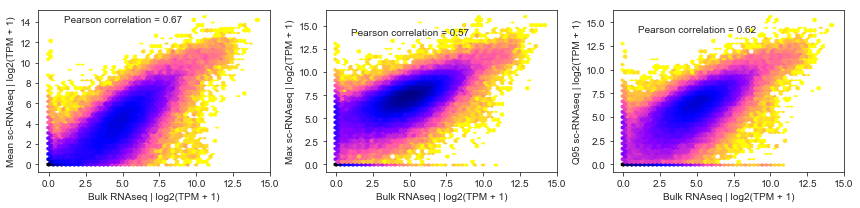

In [20]:
fig, axes = plt.subplots(figsize=(12,3), ncols=3)

for y_name, y_val, ax in zip(['Mean', 'Max', 'Q95'], [y_mean, y_max, y_q95], axes.flatten()):
    
    im = ax.hexbin(np.log2(x+1), np.log2(y_val+1), gridsize=50, bins='log', cmap='gnuplot2_r')
    ax.set_xlabel('Bulk RNAseq | log2(TPM + 1)')
    ax.set_ylabel('{} sc-RNAseq | log2(TPM + 1)'.format(y_name))
#     fig.colorbar(im, label='Log10(count + 1)')
    ax.text(x=1, y=14, s='Pearson correlation = {:.2f}'.format(stats.pearsonr(x, y_val)[0]), fontsize=10)
    
plt.tight_layout()

### Cluster frequency (per cell line)

In [21]:
cnt_per_cl_df = cell_df[['cell_line_id']].reset_index().groupby('cell_line_id').count()

In [22]:
cnt_per_cl_cluster_df = cell_df[['cell_line_id', 'cluster']].reset_index().groupby(['cell_line_id', 'cluster']).count()

In [23]:
# (cnt_per_cl_cluster_df / cnt_per_cl_df).reset_index().groupby('cell_line_id').sum()
percent_cl_cluster_df = (cnt_per_cl_cluster_df / cnt_per_cl_df) * 100
percent_cl_cluster_df.columns = ['percent']
percent_cl_cluster_df.head()

percent
cell_line_id cluster           
HN120M       A1        4.597701
             A2       95.402299
HN120P       C2        2.272727
             E1       67.045455
             E2       30.681818

In [24]:
percent_cl_cluster_df.to_excel('../preprocessed_data/HN_patient_specific/percent_cl_cluster.xlsx')

### Abundance per patients

*For HN137 at patient level, we discard HN137P2*

In [25]:
cnt_per_patient_df = cell_df[cell_df['cell_line_id']!='HN137P2'][['patient_id']].reset_index().groupby('patient_id').count()

In [26]:
cnt_per_patient_cluster_df = cell_df[cell_df['cell_line_id']!='HN137P2'][['patient_id', 'cluster']].reset_index().groupby(['patient_id', 'cluster']).count()

In [27]:
# (cnt_per_cl_cluster_df / cnt_per_cl_df).reset_index().groupby('cell_line_id').sum()
percent_patient_cluster_df = (cnt_per_patient_cluster_df / cnt_per_patient_df) * 100
percent_patient_cluster_df.columns = ['percent']
percent_patient_cluster_df.head()

percent
patient_id cluster           
HN120      A1        2.285714
           A2       47.428571
           C2        1.142857
           E1       33.714286
           E2       15.428571

In [28]:
percent_patient_cluster_df.to_excel('../preprocessed_data/HN_patient_specific/percent_patient_cluster.xlsx')

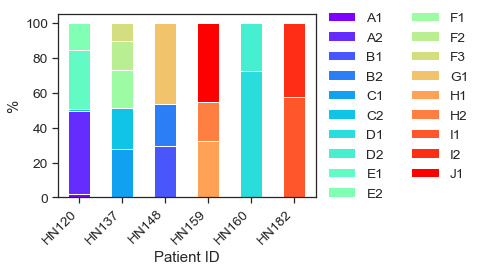

In [36]:
sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(6, 4))
percent_patient_cluster_df.reset_index().pivot_table(index='patient_id', columns='cluster', values='percent').fillna(0).plot(kind='bar', cmap='rainbow', stacked=True, ax=ax)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, framealpha=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('%')
ax.set_xlabel('Patient ID')

plt.tight_layout()

### Select essential genes

In [30]:
ess_gene_list = pd.read_csv('../data/essential_genes.txt', header=None)[0].values.astype(str)
len(ess_gene_list)

1856

In [31]:
selected_ess_gene_list = [g for g in ess_gene_list if g in tmm_df.index]
len(selected_ess_gene_list)

1729

In [32]:
tmm_df = tmm_df.loc[selected_ess_gene_list]
tmm_df.shape

(1729, 1034)

### Cluster exp profile (average TMM)

In [33]:
temp_df = tmm_df.T
temp_df = pd.merge(temp_df, cell_df, left_index=True, right_index=True)
temp_df.shape

(1034, 1738)

In [34]:
cluster_tmm_df = temp_df.groupby('cluster')[selected_ess_gene_list].mean()

In [38]:
log2_fc_cluster_tmm_df = (np.log2(cluster_tmm_df + 1) - np.log2(cluster_tmm_df + 1).mean())
log2_fc_cluster_tmm_df.head()

,AAAS,AAMP,AARS,AARS2,AASDHPPT,AATF,ABCB7,ABCE1,ABCF1,ABHD11,...,ZNF259,ZNF335,ZNF407,ZNF486,ZNF574,ZNF622,ZNF830,ZNHIT2,ZNRD1,ZWINT
cluster,,,,,,,,,,,,,,,,,,,,,
A1,0.846317,1.056943,-0.035398,0.618334,0.943819,0.778005,0.233753,0.269528,0.741846,0.080777,...,0.607385,1.585856,1.456241,-0.372015,0.812329,1.506228,0.626840,0.229868,0.327227,0.914634
A2,0.377929,-0.036515,0.437952,0.373205,-0.337211,-0.031126,0.557112,-0.261570,0.090530,0.576972,...,0.241976,-0.325217,0.084953,-0.372015,-0.596296,0.394761,0.957119,-1.051695,0.106521,1.385946
B1,-0.730985,-0.257559,-0.265018,-0.413254,1.537949,-0.926482,1.065239,1.477938,-0.748206,-1.909938,...,0.091214,-0.281327,0.471861,2.336833,-0.556074,0.333259,-1.013634,-0.677162,0.771120,0.219644
B2,0.734532,-0.098359,0.651783,-0.088507,1.188424,-0.385869,1.105859,0.964429,-0.025535,-0.097512,...,0.154228,0.202380,0.381060,1.852070,-0.484486,0.509798,-0.028903,-1.037036,1.136468,0.271651
C1,0.082111,0.459542,-0.108906,-0.753614,-1.104427,-0.676575,-0.494312,-0.542830,-1.461844,0.046482,...,-1.194204,0.178672,-0.674583,-0.372015,-0.465432,0.256377,-0.015267,0.155019,-0.750279,-0.511969


In [39]:
log2_fc_cluster_tmm_df.mean()

AAAS        2.886580e-16
AAMP       -1.332268e-15
AARS        3.108624e-16
AARS2       6.661338e-17
AASDHPPT    6.661338e-16
                ...     
ZNF622     -4.884981e-16
ZNF830     -3.330669e-16
ZNHIT2      1.443290e-16
ZNRD1       7.771561e-16
ZWINT       7.105427e-16
Length: 1729, dtype: float64

In [40]:
cluster_tmm_df.to_csv('../preprocessed_data/HN_patient_specific/cluster_tmm.csv')
log2_fc_cluster_tmm_df.to_csv('../preprocessed_data/HN_patient_specific/log2_fc_cluster_tmm.csv')

### Log2 fold-change

In [41]:
log2_fc_tmm_df = (np.log2(tmm_df.T + 1) - np.log2(tmm_df.T + 1).mean())
log2_fc_tmm_df.head()

,AAAS,AAMP,AARS,AARS2,AASDHPPT,AATF,ABCB7,ABCE1,ABCF1,ABHD11,...,ZNF259,ZNF335,ZNF407,ZNF486,ZNF574,ZNF622,ZNF830,ZNHIT2,ZNRD1,ZWINT
RHH2177,3.604245,1.547801,0.134825,-0.400194,-5.894286,0.290877,1.913821,1.066968,0.605364,4.010995,...,-2.493090,-0.797366,-1.057094,-0.173582,-0.45016,0.581480,-2.256255,-0.600158,1.227351,2.766712
RHH2178,3.754274,-1.813274,4.928656,-0.400194,-0.328808,-3.075222,2.567696,2.045692,-4.339745,-1.839847,...,-2.493090,-0.797366,-1.057094,-0.173582,-0.45016,1.278964,2.599505,-0.600158,-3.802858,3.059792
RHH2179,-2.975678,1.735483,2.054631,-0.400194,-1.315278,1.712735,1.042463,1.086850,-0.559641,-1.839847,...,1.156128,-0.797366,-1.057094,-0.173582,-0.45016,-3.717985,2.895470,-0.600158,-3.802858,2.720220
RHH2180,2.080730,0.073989,3.278427,-0.400194,-1.005465,1.864652,-3.524298,1.155783,-0.325160,1.093848,...,-2.493090,-0.797366,-1.057094,-0.173582,-0.45016,-3.717985,-0.303314,-0.600158,-3.802858,2.718671
RHH2181,-2.975678,-0.065447,2.922357,-0.400194,-5.894286,-4.629766,-3.524298,2.026911,-0.019895,2.127037,...,-2.493090,0.002431,-1.057094,-0.173582,-0.45016,-2.252253,4.073079,-0.600158,-1.000270,4.582534


In [42]:
log2_fc_tmm_df.mean()

AAAS        5.134943e-15
AAMP       -4.453132e-15
AARS        2.795958e-16
AARS2       6.880376e-16
AASDHPPT    1.905632e-15
                ...     
ZNF622     -2.434760e-15
ZNF830      2.680856e-15
ZNHIT2      1.334845e-15
ZNRD1       4.752699e-15
ZWINT       9.142912e-15
Length: 1729, dtype: float64

In [43]:
log2_fc_tmm_df.to_csv('../preprocessed_data/HN_patient_specific/log2_fc_tmm.csv')

### t-SNE 

In [44]:
from sklearn.manifold import TSNE

X = log2_fc_tmm_df.values
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1034, 2)

In [45]:
tsne_df = pd.DataFrame(X_embedded, index=log2_fc_tmm_df.index, columns=['tSNE1', 'tSNE2'])
tsne_df = pd.merge(tsne_df, cell_df, left_index=True, right_index=True)
tsne_df.head()

,tSNE1,tSNE2,patient_id,cell_line_id,origin,n_genes,percent_mito,n_counts,cluster,louvain,louvain2
RHH2177,-10.995079,-1.056891,HN120,HN120P,Primary,5756,0.089859,1108868.40,E1,4,0.0
RHH2178,-11.628449,1.207205,HN120,HN120P,Primary,6667,0.117073,983562.75,E1,4,0.0
RHH2179,-9.657337,-1.532824,HN120,HN120P,Primary,7092,0.104110,1029287.70,E2,4,1.0
RHH2180,-10.479979,-1.116340,HN120,HN120P,Primary,7277,0.111613,1025364.90,E1,4,0.0
RHH2181,-11.866436,-0.847186,HN120,HN120P,Primary,6387,0.133514,986050.25,E1,4,0.0


In [46]:
tsne_df.to_csv('../preprocessed_data/HN_patient_specific/tsne.csv')